In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from craftax.craftax_env import make_craftax_env_from_name
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from craftax.craftax.renderer import render_craftax_pixels
from craftax.craftax import constants
import matplotlib.pyplot as plt
import craftax_env
from craftax.craftax.constants import Action

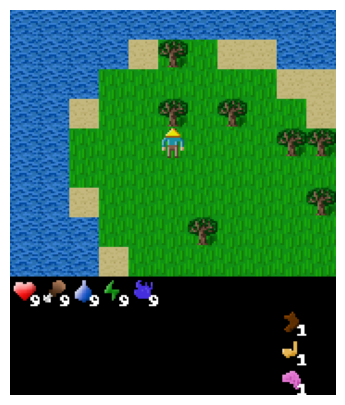


Currently achievable:
- Collect Wood


In [35]:
from IPython.display import display
import ipywidgets as widgets
from enum import Enum

class KeyboardController:
    def __init__(self, env, render_fn):
        self.env = env
        self.render_fn = render_fn
        self.rng = jax.random.PRNGKey(0)
        self.env_params = env.default_params
        self.env_state = None
        self.action = None
        
        # Create output widget for displaying the game
        self.output = widgets.Output()
        
        # Create and display the controller widget
        self.controller = widgets.Text(
            value='Click here and use arrow keys to move',
            description='Controls:',
            disabled=True  # Make it read-only
        )
        
        # Register keyboard events
        self.controller.observe(self.handle_key_event, names='value')
        
        # Initialize the game
        self.reset_game()
        
        # Display widgets
        return display(widgets.VBox([self.controller, self.output]))
    
    def handle_key_event(self, change):
        # Map keys to actions
        action_map = {
            'a': Action.LEFT.value,    # Left arrow
            'd': Action.RIGHT.value,   # Right arrow
            'w': Action.UP.value,      # Up arrow
            's': Action.DOWN.value,    # Down arrow
        }
        
        # Get the key pressed
        key = change.new
        
        # Reset the text field
        self.controller.value = 'Click here and use arrow keys to move'
        
        # Check if it's a valid action
        if key in action_map:
            self.action = action_map[key]
            self.step_game()
    
    def reset_game(self):
        self.rng, rng_reset = jax.random.split(self.rng)
        obs, self.env_state = self.env.reset_env(rng_reset, self.env_params)
        self.render_game()
        
    def step_game(self):
        self.rng, rng_step = jax.random.split(self.rng)
        obs, self.env_state, reward, done, info = self.env.step_env(
            rng_step, self.env_state, self.action, self.env_params
        )
        
        self.render_game()
        
        if done:
            self.reset_game()
    
    def render_game(self):
        with self.output:
            self.output.clear_output(wait=True)
            image = self.render_fn(self.env_state)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            
            # Display possible achievements
            possible = craftax_env.get_possible_achievements(self.env_state)
            craftax_env.print_possible_achievements(possible)

# Create and start the controller
controller = KeyboardController(env, render_craftax)

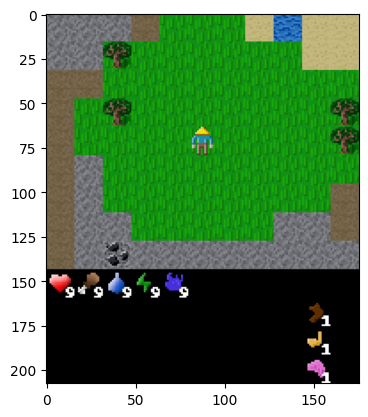

start 0

Currently achievable:
- Collect Wood


In [57]:
render = jax.jit(partial(render_craftax_pixels, block_pixel_size=constants.BLOCK_PIXEL_SIZE_IMG))
def render_craftax(state):
    image = render_craftax_pixels(state, block_pixel_size=constants.BLOCK_PIXEL_SIZE_IMG)
    return image/255.0
    
render_craftax = jax.jit(render_craftax)

env = make_craftax_env_from_name("Craftax-Symbolic-v1", auto_reset=True)
env_params = env.default_params.replace(
    mob_despawn_distance=3,
    day_length=3,
)

seed = 10
rng = jax.random.PRNGKey(seed)

obs, env_state = env.reset_env(rng, env_params)
image = render_craftax(env_state)
plt.imshow(image)
plt.show()
possible = craftax_env.get_possible_achievements(env_state)
craftax_env.print_possible_achievements(possible)

# for _ in range(10):
#     rng, rng_ = jax.random.split(rng)
#     action = env.action_space().sample(rng_)
#     action = jnp.array(Action.LEFT.value, dtype=action.dtype)
#     obs, env_state, reward, done, info = env.step_env(rng, env_state, action, env_params)
#     image = render_craftax(env_state)
#     plt.imshow(image)
#     plt.show()
#     possible = craftax_env.get_possible_achievements(env_state)
#     craftax_env.print_possible_achievements(possible)


In [47]:
possible

Array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [42]:
env_state.inventory.wood, env_state.inventory.stone, env_state.inventory.iron, env_state.inventory.coal

(Array(0, dtype=int32),
 Array(0, dtype=int32),
 Array(0, dtype=int32),
 Array(0, dtype=int32))

In [36]:
craftax_env.print_possible_achievements(jnp.ones_like(possible))


Currently achievable:
- Cast Fireball
- Cast Iceball
- Collect Coal
- Collect Diamond
- Collect Drink
- Collect Iron
- Collect Ruby
- Collect Sapling
- Collect Sapphire
- Collect Stone
- Collect Wood
- Damage Necromancer
- Defeat Archer
- Defeat Deep Thing
- Defeat Fire Elemental
- Defeat Frost Troll
- Defeat Gnome Archer
- Defeat Gnome Warrior
- Defeat Ice Elemental
- Defeat Knight
- Defeat Kobold
- Defeat Lizard
- Defeat Necromancer
- Defeat Orc Mage
- Defeat Orc Solider
- Defeat Pigman
- Defeat Skeleton
- Defeat Troll
- Defeat Zombie
- Drink Potion
- Eat Bat
- Eat Cow
- Eat Plant
- Eat Snail
- Enchant Armour
- Enchant Sword
- Enter Dungeon
- Enter Fire Realm
- Enter Gnomish Mines
- Enter Graveyard
- Enter Ice Realm
- Enter Sewers
- Enter Troll Mines
- Enter Vault
- Find Bow
- Fire Bow
- Learn Fireball
- Learn Iceball
- Make Arrow
- Make Diamond Armour
- Make Diamond Pickaxe
- Make Diamond Sword
- Make Iron Armour
- Make Iron Pickaxe
- Make Iron Sword
- Make Stone Pickaxe
- Make Sto